In [3]:

import sys
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D,MaxPooling2D, Activation, Dropout, BatchNormalization, Input
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import itertools  
import efficientnet.keras as efn 
from keras.models import Model


In [4]:
# base_model = efn.EfficientNetB0(weights='imagenet', include_top=False)

img_rows = 28
img_cols = 28
batch_size = 50

input_tensor = Input(shape=(img_rows, img_cols, 3))

base_model = efn.EfficientNetB0(input_tensor=input_tensor, weights='imagenet', include_top=True)


In [5]:
base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 14, 14, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 14, 14, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 14, 14, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________

In [6]:
feature_layer = base_model.layers[-2].output

In [7]:
classification_layer = Dense(10, activation='softmax')(feature_layer)

In [8]:
model = Model(base_model.input, classification_layer)



In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 14, 14, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 14, 14, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 14, 14, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [ ]:
path = "mnistasjpg/trainingSet/"
train_data_path = path+"trainingSet"
# test_data_path = path+"test"
# valid_data_path = path+"valid"

In [ ]:
#Image Generator
#Image Generator
# train_datagen = ImageDataGenerator(rescale=1. / 255,
#                                    rotation_range=40,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest')
train_datagen = ImageDataGenerator(zoom_range=0.5)
# train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical', shuffle=False)

# valid_datagen = ImageDataGenerator()
# valid_generator = valid_datagen.flow_from_directory(valid_data_path,
#                                                     target_size=(img_rows, img_cols),
#                                                     batch_size=batch_size,
#                                                     class_mode='categorical', shuffle=True)

# test_datagen = ImageDataGenerator()
# test_generator = test_datagen.flow_from_directory(test_data_path,
#                                                     target_size=(img_rows, img_cols),
#                                                     batch_size=batch_size,
#                                                     class_mode='categorical', shuffle=False)

In [ ]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(24,24), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
#     print(cols, rows)
    for i in range(len(ims)):
        sp = f.add_subplot(cols, rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [ ]:
imgs, labels = next(train_generator)


In [ ]:
print(train_generator.class_indices)
plots(imgs, titles=labels)

In [ ]:
# model = Sequential([Conv2D(6, (3, 3), activation='relu', 
#                            input_shape=(img_rows, img_cols, 3)), 
#                     Flatten(), 
#                     Dense(10, activation='softmax')
#                    ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=20, epochs=55)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

In [ ]:
#Confusion Matrix and Classification Report
Y_pred = model.predict_generator(train_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(train_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [13]:
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.utils import plot_model


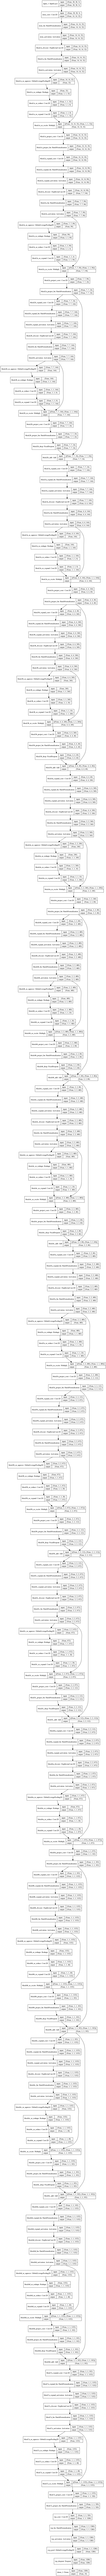

In [15]:
plot_model(model, to_file='model.png', show_shapes = True)

# SVG(model_to_dot(model).create(prog='dot', format='svg'))